# Project Summary: Orthopedic Patient Classification

## Objective

The primary objective of this project was to classify orthopedic patients into two categories: Normal (NO) and Abnormal (AB), using biomechanical features related to their spine and pelvis. This precise classification assists healthcare professionals in effectively diagnosing spinal disorders.

## Dataset Description

The dataset consists of 310 records containing six biomechanical attributes:

* Pelvic Incidence
* Pelvic Tilt
* Lumbar Lordosis Angle
* Sacral Slope
* Pelvic Radius
* Grade of Spondylolisthesis

Data was initially provided without headers and required preprocessing for proper utilization.

## Exploratory Data Analysis (EDA) & Data Preprocessing

Initial steps involved:

* Adding appropriate column headers based on metadata.
* Converting data types from object to numerical (float64).
* Identifying and addressing a significant class imbalance (AB: 210, NO: 100) using Synthetic Minority Oversampling Technique (SMOTE), increasing data samples to 398.

Further analysis included:

* Histograms to visualize feature distributions, revealing a heavily skewed grade of spondylolisthesis.
* Log transformation and value shifting applied to handle skewness and negative values.
* MinMax scaling to normalize all features between 0 and 1.
* Pair plots and correlation matrices to identify relationships and potential patterns among variables.

## Dimensionality Reduction

Principal Component Analysis (PCA) was applied, and based on the scree plot analysis, the first three principal components were selected, accounting for approximately 85-90% of the dataset's variance, aiding interpretability and computational efficiency.

## Methodologies

### Unsupervised Clustering: Gaussian Mixture Model (GMM) with Expectation-Maximization (EM)

* Chosen for its ability to model overlapping clusters and soft clustering advantages.
* PCA-reduced data utilized for clarity and interpretability.
* Data split into training and testing sets (80-20) with stratified sampling.

### Supervised Classification: K-Nearest Neighbors (KNN)

* Selected for its simplicity and effectiveness, suitable for complex biomedical data.
* Euclidean distance employed as the distance metric.
* Hyperparameter optimization conducted via GridSearchCV to find optimal k-value.
* Data balanced using SMOTE prior to training.

## Results

* **Supervised KNN Model:**

  * Accuracy: 87%
  * Precision (AB): 95%, Recall (AB): 86%, F1-score (AB): 90%
  * Precision (NO): 75%, Recall (NO): 90%, F1-score (NO): 82%

* **Unsupervised PCA+GMM+EM Model:**

  * Accuracy: 82%
  * Precision (AB): 97%, Recall (AB): 76%, F1-score (AB): 85%
  * Precision (NO): 66%, Recall (NO): 95%, F1-score (NO): 78%

Visualizations clearly depicted cluster separations and overlaps.

## Performance Comparison

The supervised KNN model provided more balanced and superior predictive performance, particularly suited for clinical diagnostics. The unsupervised PCA+GMM+EM model offered significant exploratory insights, especially effective at capturing genuine normal cases.

## Conclusion

The project showcased the efficacy of machine learning for medical classification tasks. Thorough EDA and preprocessing provided a robust foundation for modeling. Supervised learning via KNN emerged as highly effective for clinical decision-making, while unsupervised clustering offered valuable exploratory analysis capabilities.

## Key Techniques & Tools Used

* Python Libraries: pandas, numpy, matplotlib, seaborn, scikit-learn, imblearn
* Techniques: PCA, SMOTE, MinMaxScaler, log transformation, GridSearchCV

This comprehensive approach demonstrated robust methodologies for handling biomedical data classification challenges.


In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale

In [2]:
df = pd.read_csv('vertebral_column_data.csv', header = None)
df = df[0].str.split(expand=True)

# Assign correct column names
df.columns = [
    "pelvic_incidence",
    "pelvic_tilt",
    "lumbar_lordosis_angle",
    "sacral_slope",
    "pelvic_radius",
    "grade_of_spondylolisthesis",
    "class"
]

In [3]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,grade_of_spondylolisthesis,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB
1,39.06,10.06,25.02,29,114.41,4.56,AB
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB
3,69.3,24.65,44.31,44.64,101.87,11.21,AB
4,49.71,9.65,28.32,40.06,108.17,7.92,AB


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   pelvic_incidence            310 non-null    object
 1   pelvic_tilt                 310 non-null    object
 2   lumbar_lordosis_angle       310 non-null    object
 3   sacral_slope                310 non-null    object
 4   pelvic_radius               310 non-null    object
 5   grade_of_spondylolisthesis  310 non-null    object
 6   class                       310 non-null    object
dtypes: object(7)
memory usage: 17.1+ KB


In [5]:
numeric_cols = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 
                'sacral_slope', 'pelvic_radius', 'grade_of_spondylolisthesis']

# Convert the required columns to float 
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [6]:
df['class'].value_counts()

class
AB    210
NO    100
Name: count, dtype: int64

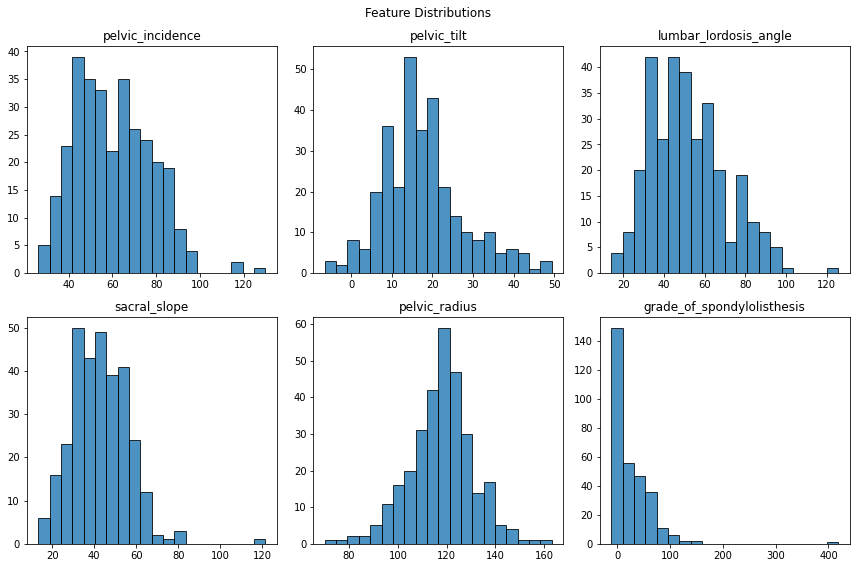

In [7]:
feature_cols = [col for col in df.columns if col != 'class']


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    axes[i].hist(df[col], bins=20, alpha=0.8, edgecolor="black")
    axes[i].set_title(col)
    
plt.suptitle("Feature Distributions")
plt.tight_layout()
plt.show()

In [8]:
# min value in grade_of_spondylolisthesis
min_value = df["grade_of_spondylolisthesis"].min()
shift_value = abs(min_value) + 1  # make all values +ve

print(f"Minimum value before shift: {min_value}")
print(f"Shifting all values by: {shift_value}")


df["grade_of_spondylolisthesis_shifted"] = df["grade_of_spondylolisthesis"] + shift_value

# log transformation
df["grade_of_spondylolisthesis_log"] = np.log1p(df["grade_of_spondylolisthesis_shifted"])

# Drop other columns and keep only log grade_of_spondylolisthesis
df.drop(columns=["grade_of_spondylolisthesis", "grade_of_spondylolisthesis_shifted"], inplace=True)

Minimum value before shift: -11.06
Shifting all values by: 12.06


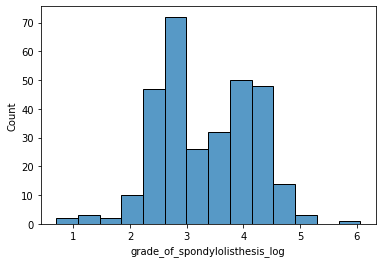

In [9]:
sns.histplot(df["grade_of_spondylolisthesis_log"])

plt.show() 


In [10]:

min_value = df["grade_of_spondylolisthesis_log"].min()
max_value = df["grade_of_spondylolisthesis_log"].max()

print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")


Minimum value: 0.6931471805599453
Maximum value: 6.0674992333839795


In [11]:
#scaling data for meaninful comparisons

feature_cols = [col for col in df.columns if col != "class"]

scaler = MinMaxScaler()

df_scaled_features = scaler.fit_transform(df[feature_cols])

df_scaled_features = pd.DataFrame(df_scaled_features, columns=feature_cols, index=df.index)

#combine the scaled features with class column
df_scaled = df_scaled_features.copy()
df_scaled["class"] = df["class"]

print(df_scaled)

     pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0            0.355710     0.519829               0.229193      0.250879   
1            0.124518     0.296713               0.098622      0.144642   
2            0.411651     0.513934               0.322982      0.307607   
3            0.416184     0.557342               0.271255      0.289376   
4            0.227238     0.289389               0.128155      0.246992   
..                ...          ...                    ...           ...   
305          0.209780     0.360307               0.196886      0.193596   
306          0.268036     0.487138               0.136209      0.183694   
307          0.340471     0.522329               0.287900      0.234870   
308          0.184221     0.272240               0.246823      0.214603   
309          0.074171     0.207574               0.202613      0.142513   

     pelvic_radius  grade_of_spondylolisthesis_log class  
0         0.307452                      

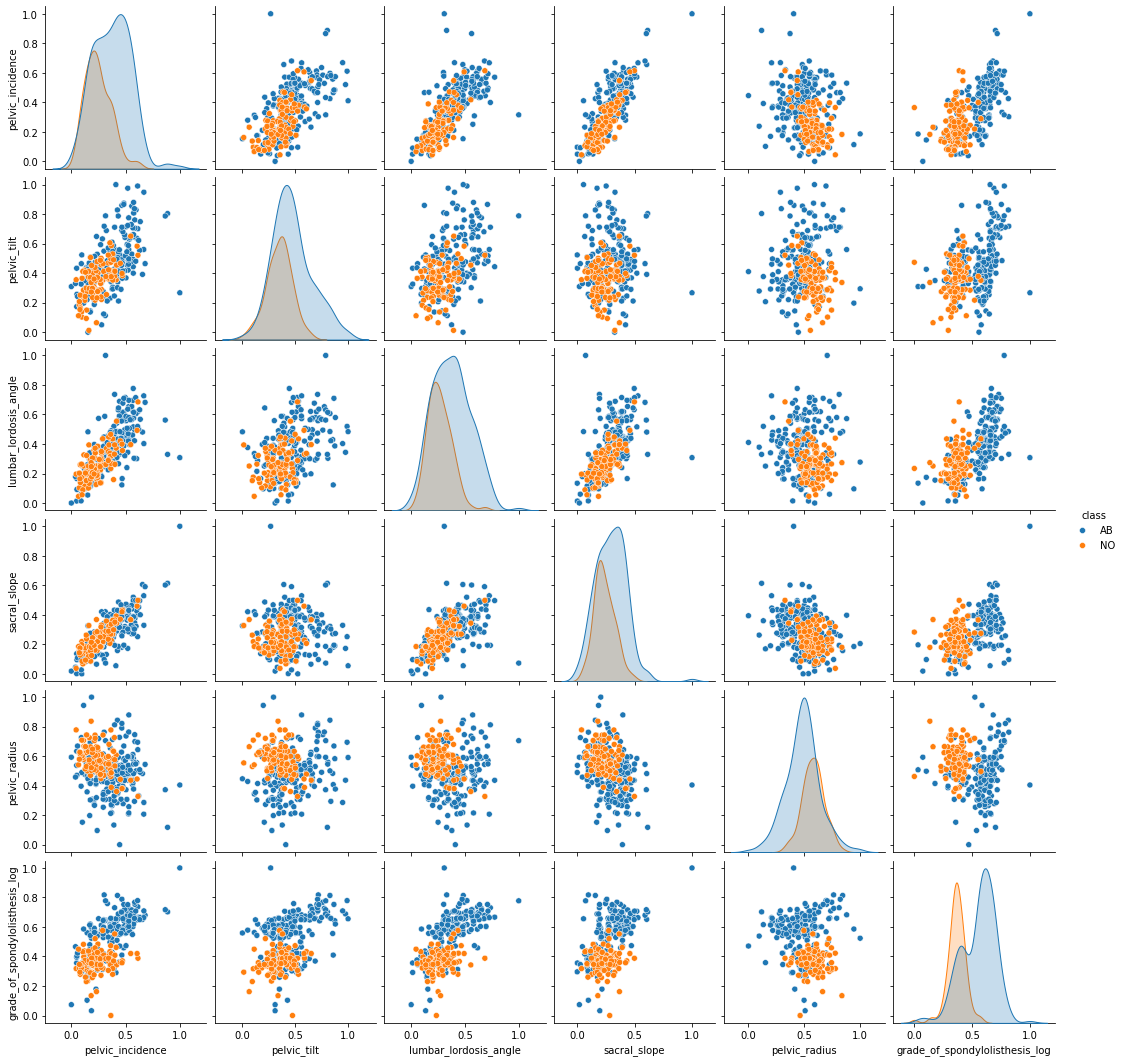

In [12]:
#EDA
sns.pairplot(df_scaled, hue="class", diag_kind="kde")
plt.show()

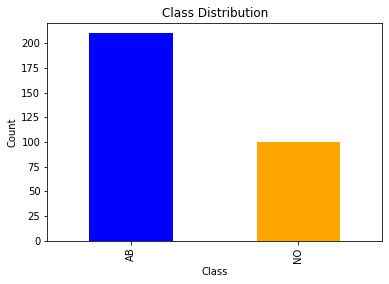

In [14]:
df_scaled["class"].value_counts().plot(kind="bar", color=['blue', 'orange'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()
# Before SMOTE
#unique, counts = np.unique(y_train, return_counts=True)
#print("Class distribution before SMOTE:", dict(zip(unique, counts)))


In [21]:
# Before SMOTE
unique, counts = np.unique(df_scaled["class"], return_counts=True)
print("Class distribution before SMOTE:", dict(zip(unique, counts)))


Class distribution before SMOTE: {'AB': 210, 'NO': 100}


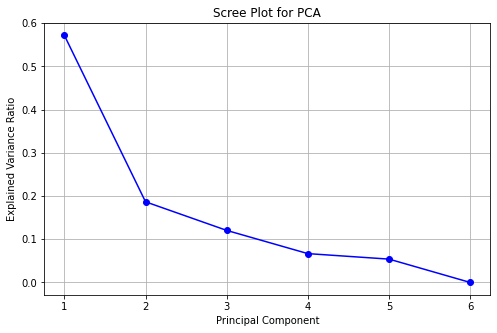

In [22]:
# Performing the PCA on the scaled features
pca = PCA()
pca.fit(df_scaled_features)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-', color='b')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot for PCA')
plt.xticks(np.arange(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()

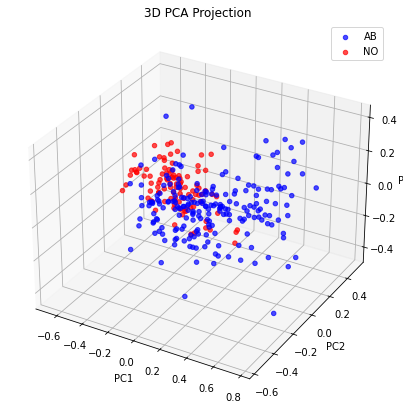

In [23]:
# Perform PCA with 3 components
pca_3d = PCA(n_components=3)
principal_components_3d = pca_3d.fit_transform(df_scaled_features)

# Create a DataFrame with the three principal components
df_pca_3d = pd.DataFrame(principal_components_3d, columns=["PC1", "PC2", "PC3"])
df_pca_3d["class"] = df["class"]  # Add the class labels

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Map classes to colors
colors = {'AB': 'b', 'NO': 'r'}

# Scatter plot
for class_label in df_pca_3d["class"].unique():
    subset = df_pca_3d[df_pca_3d["class"] == class_label]
    ax.scatter(subset["PC1"], subset["PC2"], subset["PC3"], c=colors[class_label], label=class_label, alpha=0.7)

# Labels and title
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Projection")
ax.legend()

plt.show()

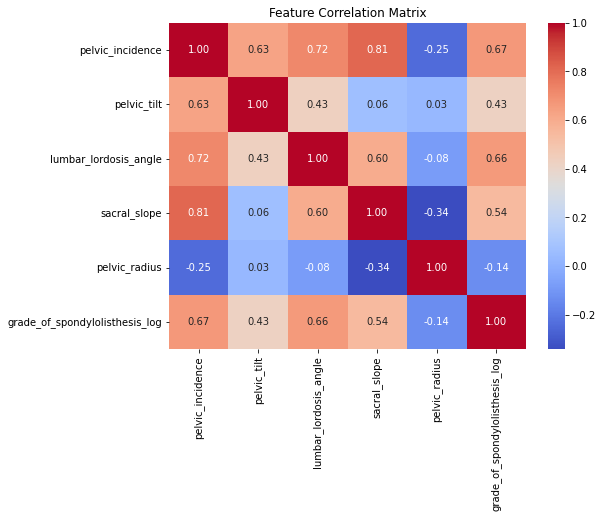

In [24]:
plt.figure(figsize=(8,6))
sns.heatmap(df_scaled[feature_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [25]:
# Extract features (X) and target (y)
X = df_scaled.iloc[:, :-1]  
y = df_scaled.iloc[:, -1]  

# Split the data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Applying SMOTE to the training data for class imbalance
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

unique, counts = np.unique(y_train_sm, return_counts=True)
print("Class distribution after SMOTE:", dict(zip(unique, counts)))



Class distribution after SMOTE: {'AB': 168, 'NO': 168}


c:\Users\Pratishtha Singh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


# KNN

In [26]:
knn_all = KNeighborsClassifier(n_neighbors=5)
knn_all.fit(X_train_sm, y_train_sm)

# Predicting on the test set
y_pred_all = knn_all.predict(X_test)

# Evaluating the performance with confusion matrix and classification report
print("KNN with All Features:")
print(confusion_matrix(y_test, y_pred_all))
print(classification_report(y_test, y_pred_all))



KNN with All Features:
[[36  6]
 [ 2 18]]
              precision    recall  f1-score   support

          AB       0.95      0.86      0.90        42
          NO       0.75      0.90      0.82        20

    accuracy                           0.87        62
   macro avg       0.85      0.88      0.86        62
weighted avg       0.88      0.87      0.87        62



# Unsupervised

In [27]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_enc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [28]:
X_train_enc, X_test_enc, y_train_enc,y_test_enc = train_test_split(X, y_enc, test_size=0.2, stratify=y)
smote = SMOTE(random_state=42)
X_train_sm_enc, y_train_sm_enc = smote.fit_resample(X_train_enc, y_train_enc)

c:\Users\Pratishtha Singh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


# GMM with EM

With PCA and EM Algorithm
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.96      0.62      0.75        42
           1       0.54      0.95      0.69        20

    accuracy                           0.73        62
   macro avg       0.75      0.78      0.72        62
weighted avg       0.83      0.73      0.73        62



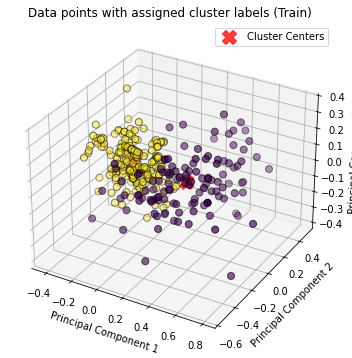

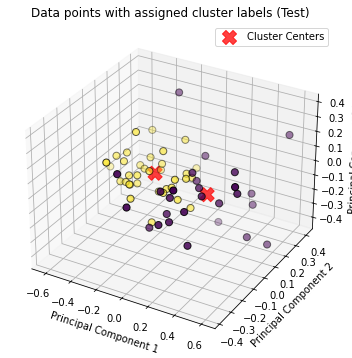

In [34]:
from sklearn.mixture import GaussianMixture
from scipy.stats import mode


# Applying PCA
pca = PCA(n_components=3)  # Using 3 principal components
X_train_pca_enc = pca.fit_transform(X_train_sm_enc)
X_test_pca_enc = pca.transform(X_test_enc)

# Applying Gaussian Mixture Model (EM Algorithm)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_train_pca_enc)

# Assigning hard labels (Cluster with Highest Probability)
hard_labels_train_enc = gmm.predict(X_train_pca_enc)
hard_labels_test_enc = gmm.predict(X_test_pca_enc)

# Mapping clusters to original labels using majority voting
mapped_labels_train_enc = np.zeros_like(hard_labels_train_enc)
mapped_labels_test_enc = np.zeros_like(hard_labels_test_enc)
for cluster in np.unique(hard_labels_train_enc):
    if np.any(hard_labels_train_enc == cluster):
        majority_label_enc = mode(y_train_sm_enc[hard_labels_train_enc == cluster]).mode[0]
    else:
        majority_label_enc = 0  # Default label if cluster is empty

    mapped_labels_train_enc[hard_labels_train_enc == cluster] = majority_label_enc
    mapped_labels_test_enc[hard_labels_test_enc == cluster] = majority_label_enc  # Use the same mapping for the test set

print('With PCA and EM Algorithm')
report_train = classification_report(y_train_sm_enc, mapped_labels_train_enc)
report_test = classification_report(y_test_enc, mapped_labels_test_enc)
# print("Classification Report (Train):\n", report_train)
print("Classification Report (Test):\n", report_test)

# Plotting the training data points with their assigned cluster labels in 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_pca_enc[:, 0], X_train_pca_enc[:, 1], X_train_pca_enc[:, 2], c=mapped_labels_train_enc, cmap='viridis', marker='o', edgecolor='k', s=50)
ax.set_title('Data points with assigned cluster labels (Train)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Plotting the cluster centers
centers = gmm.means_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', s=200, alpha=0.75, marker='X', label='Cluster Centers')

plt.legend()
plt.show()

# Plotting the test data points with their assigned cluster labels in 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_test_pca_enc[:, 0], X_test_pca_enc[:, 1], X_test_pca_enc[:, 2], c=mapped_labels_test_enc, cmap='viridis', marker='o', edgecolor='k', s=50)
ax.set_title('Data points with assigned cluster labels (Test)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Plotting the cluster centers
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', s=200, alpha=0.75, marker='X', label='Cluster Centers')

plt.legend()
plt.show()